# Imports

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt 
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
import os

# Input

In [28]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

## Drop ID

In [29]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Data visualization

## Target

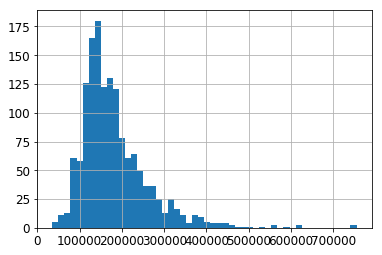

In [30]:
train['SalePrice'].hist(bins = 50)

## Lack of data

In [31]:
def lack(features):
    data_features_na = features.isnull().sum()
    data_features_na = data_features_na[data_features_na>0]
    print(data_features_na.sort_values(ascending=False))
    
lack(pd.concat([train.drop(['SalePrice'], axis=1), test]).reset_index(drop=True))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64


## Each feature

36


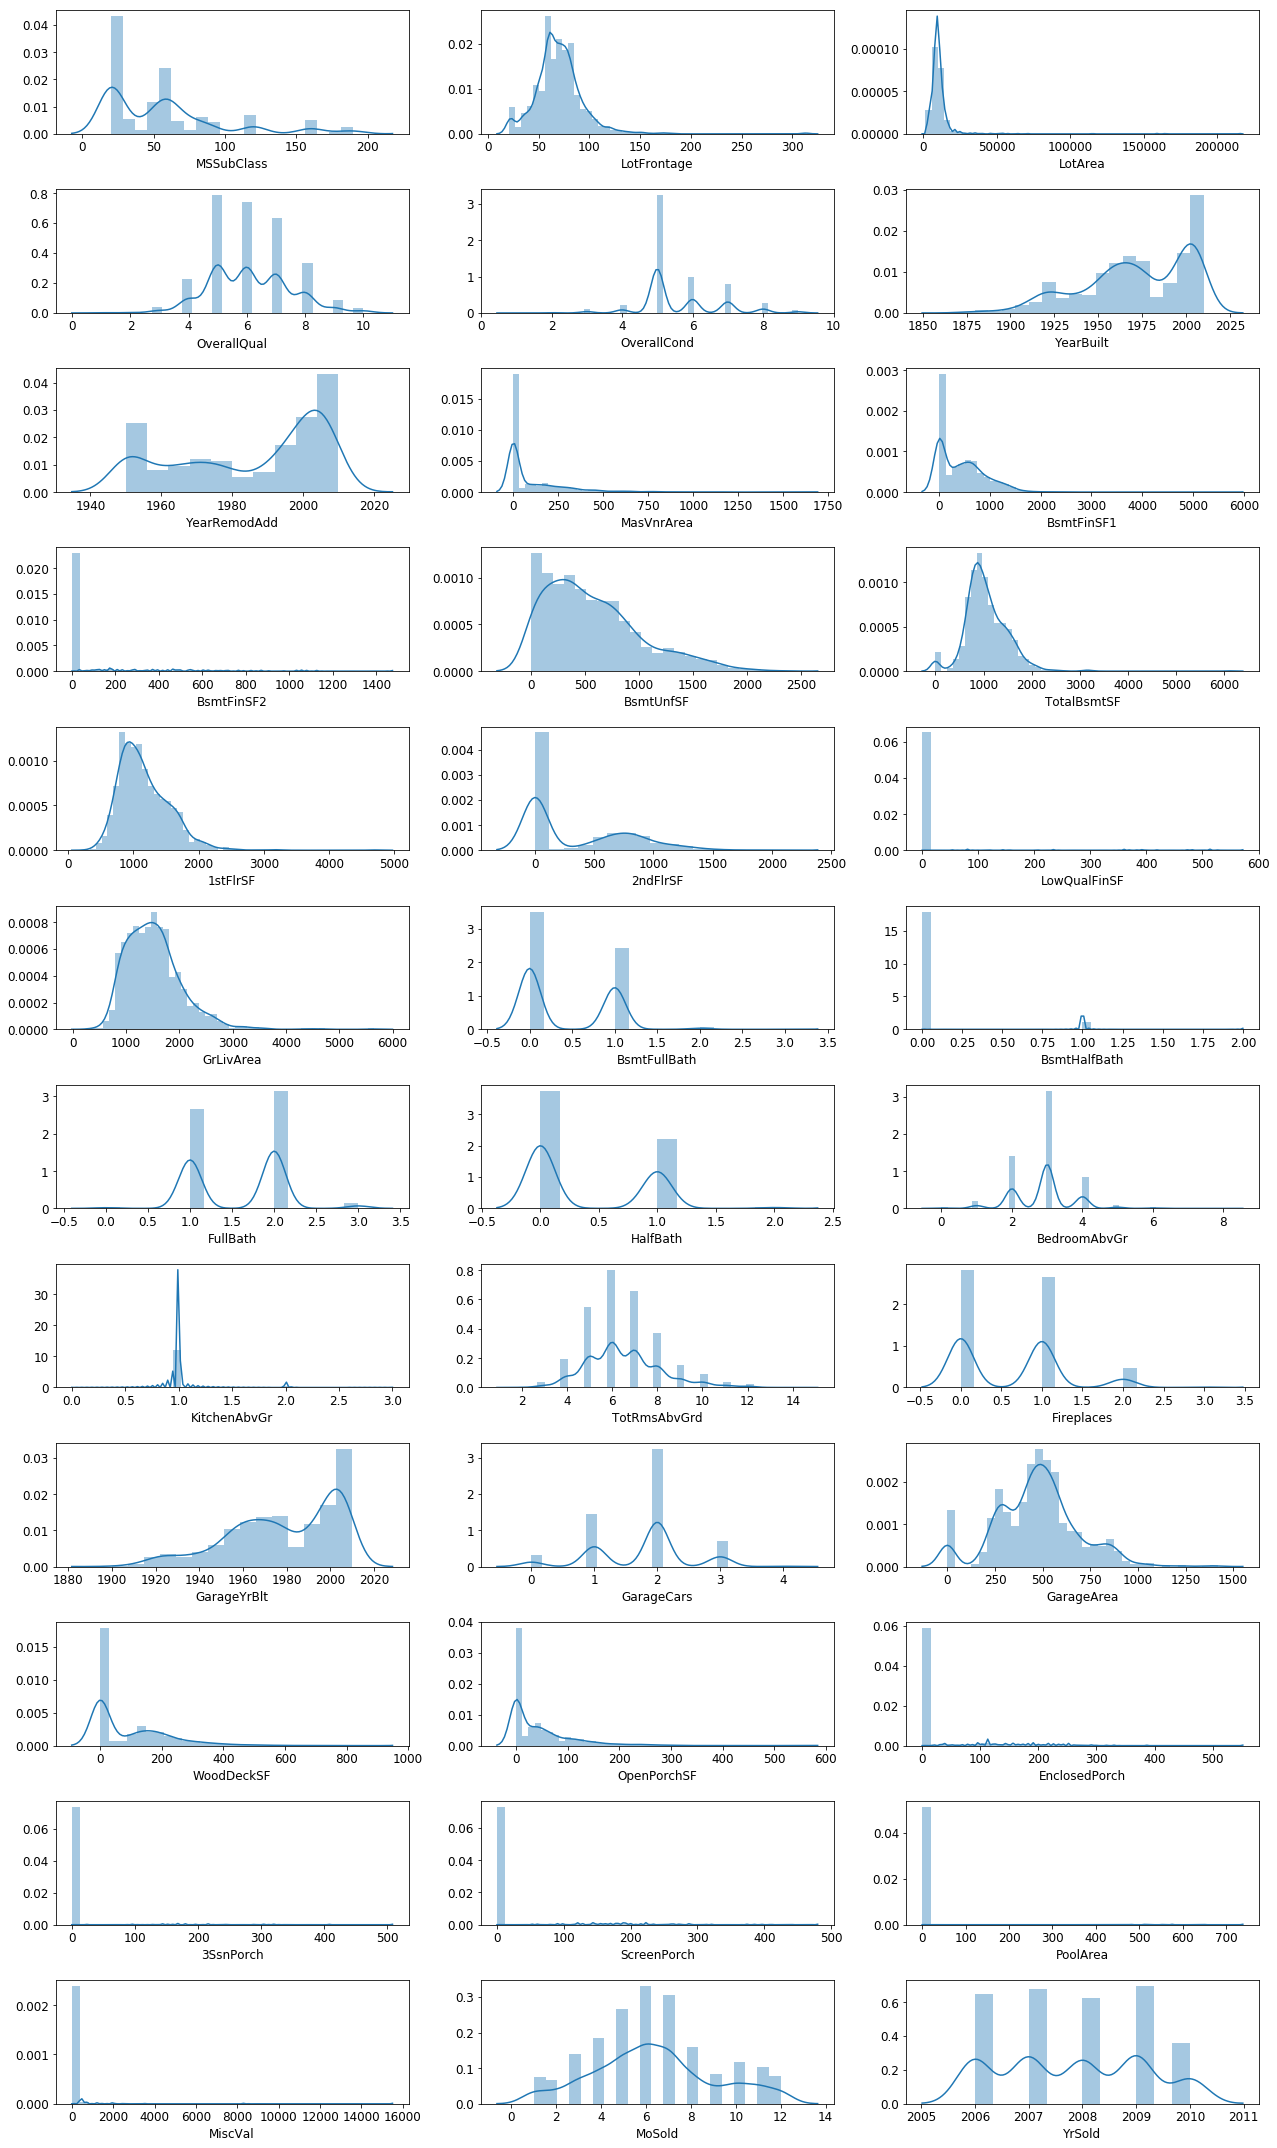

In [32]:
plt.rcParams.update({'font.size': 12})
numerical_features = train.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1).copy()
fig = plt.figure(figsize=(18,30))
print(len(numerical_features.columns))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(12,3,i+1)
    sns.distplot(numerical_features.iloc[:,i].dropna())
    plt.xlabel(numerical_features.columns[i])
plt.tight_layout()
plt.show()

## Feature comparison with SalePrice

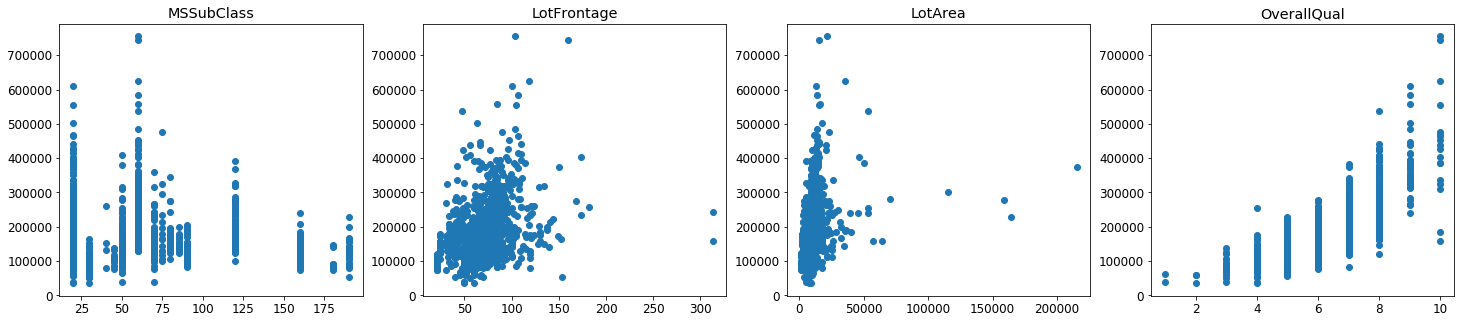

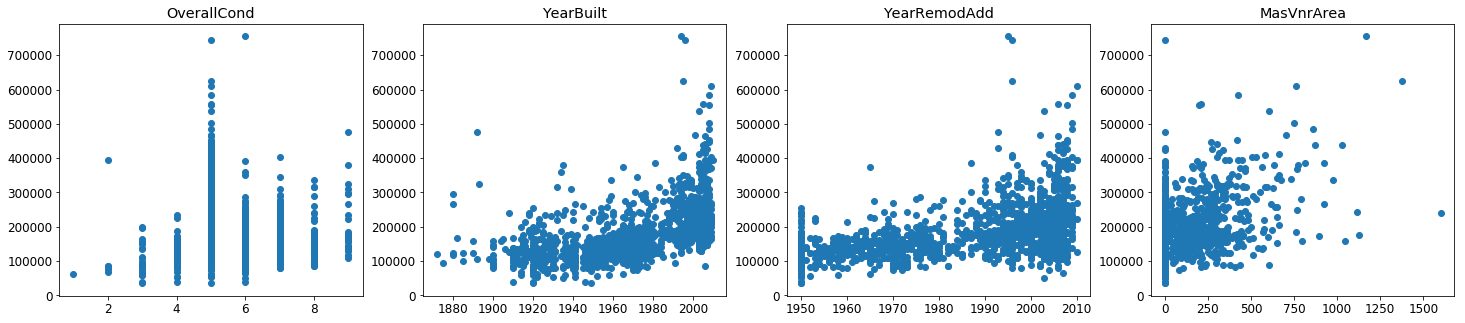

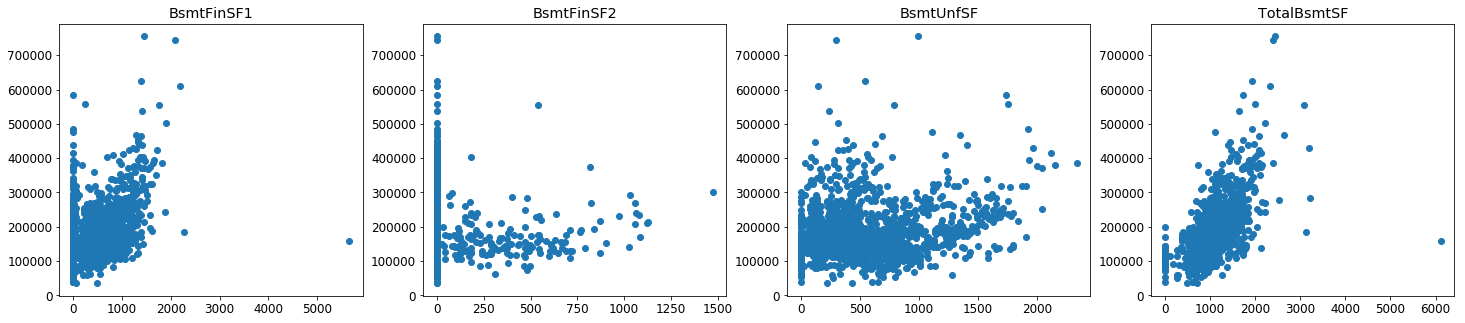

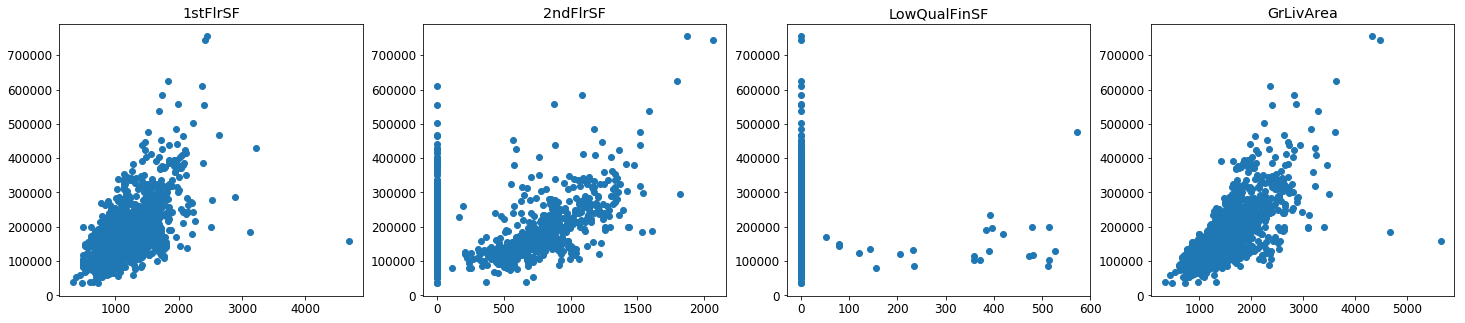

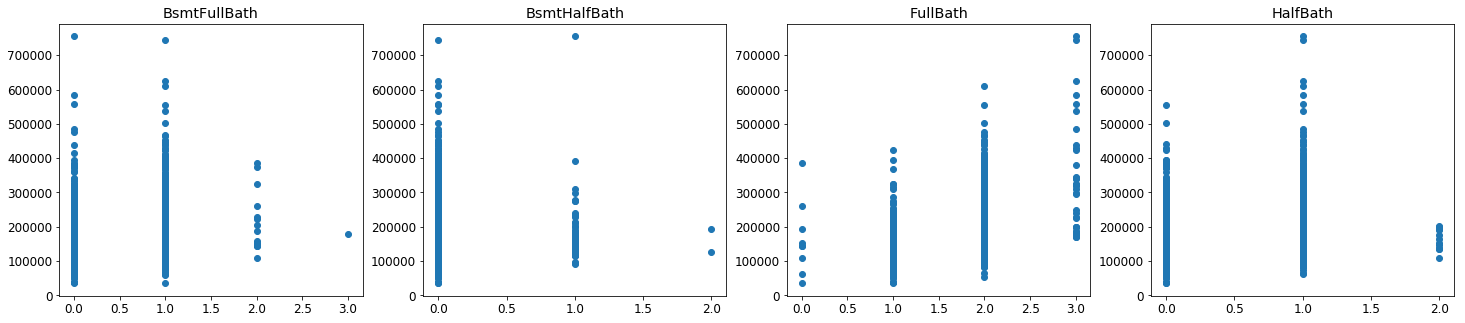

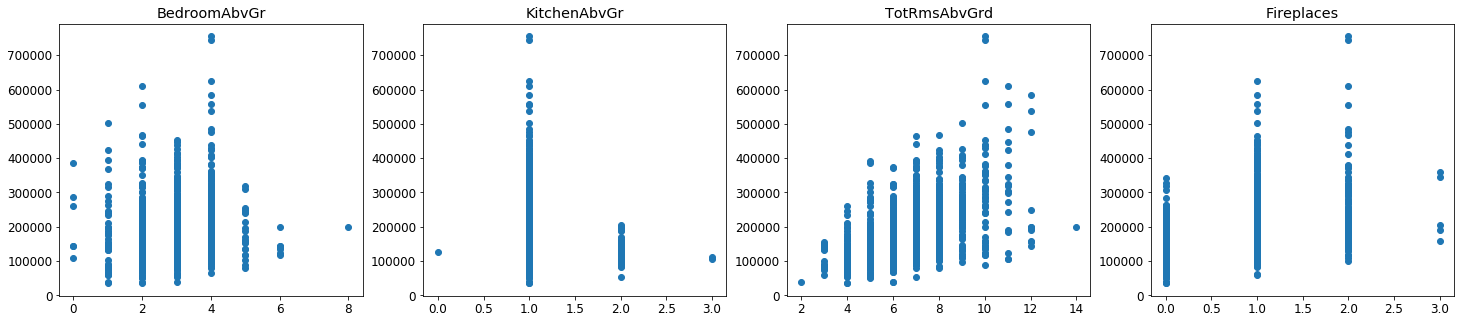

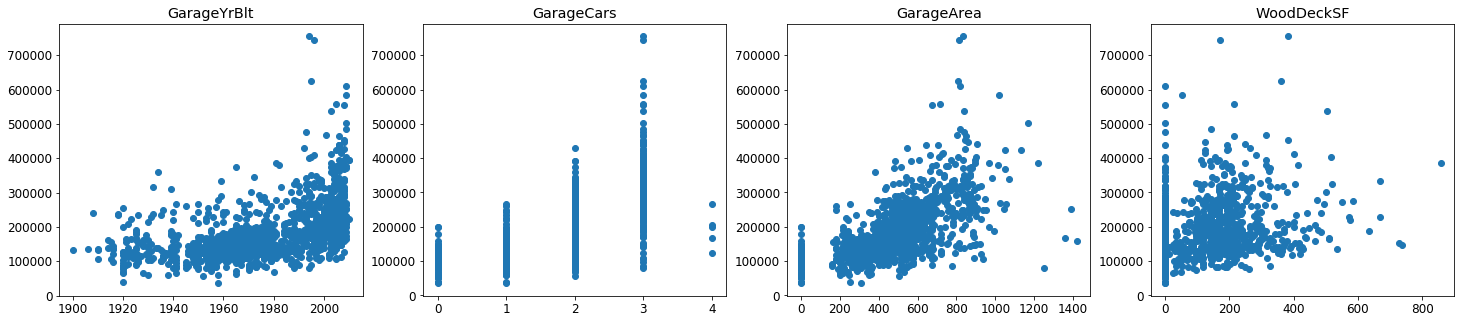

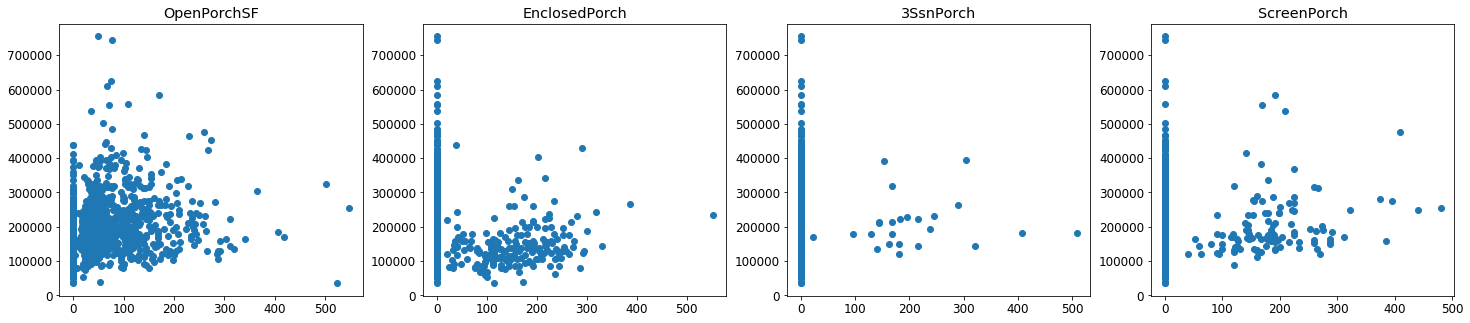

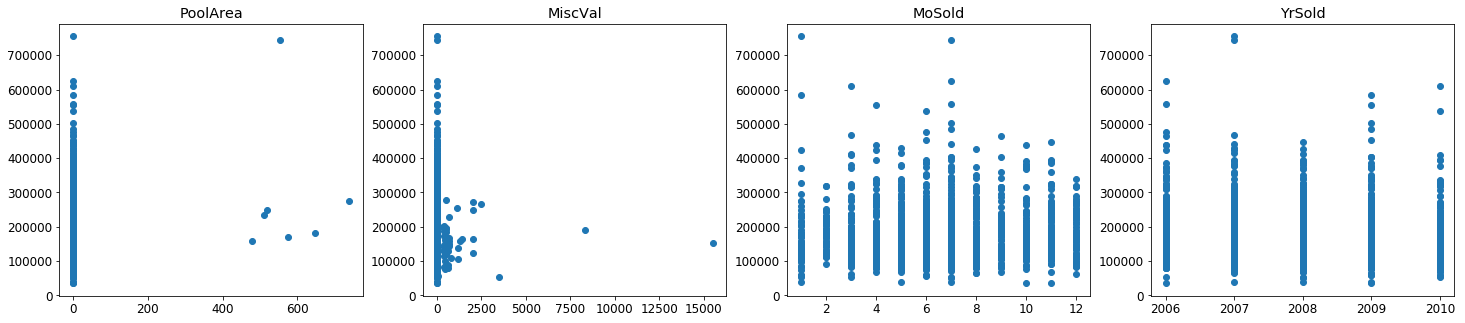

In [33]:
figures_per_time = 4
count = 0 
y = train['SalePrice']
for var in numerical_features:
    x = train[var]
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,4)+1)
    plt.scatter(x, y);
    plt.title(var)
    count+=1

## Heatmap correlation

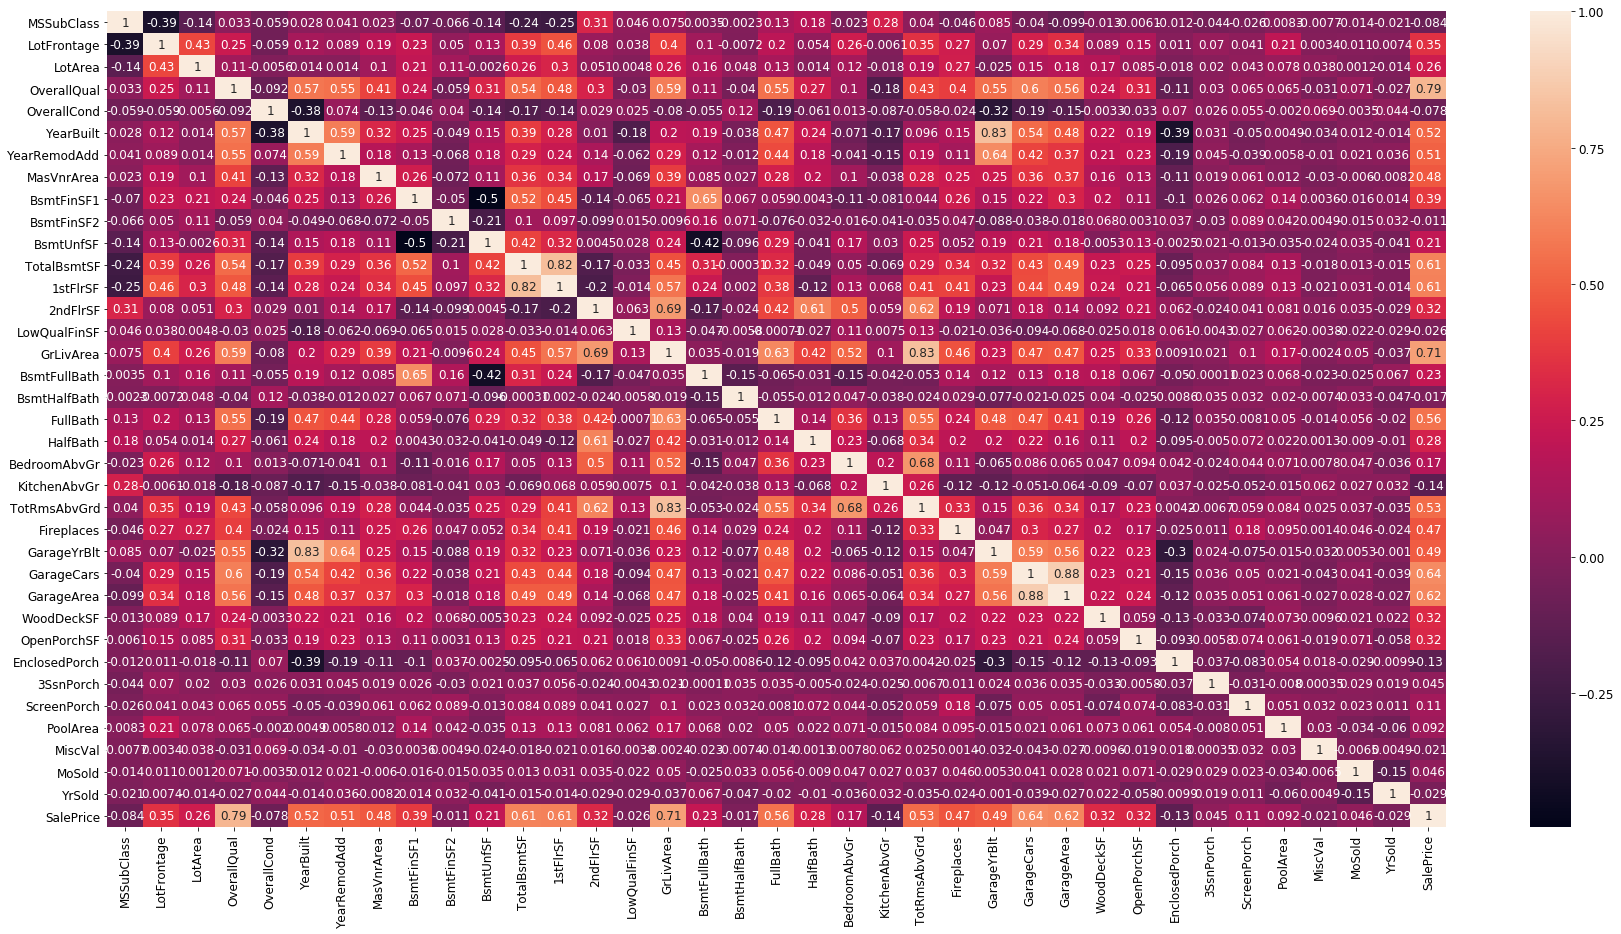

In [34]:
plt.figure(figsize=[30,15])
#Heatmap lookup
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other.
#If these variables are correlated with each other, then we need to keep only one of them and drop the rest.
sns.heatmap(train.corr(), annot=True)

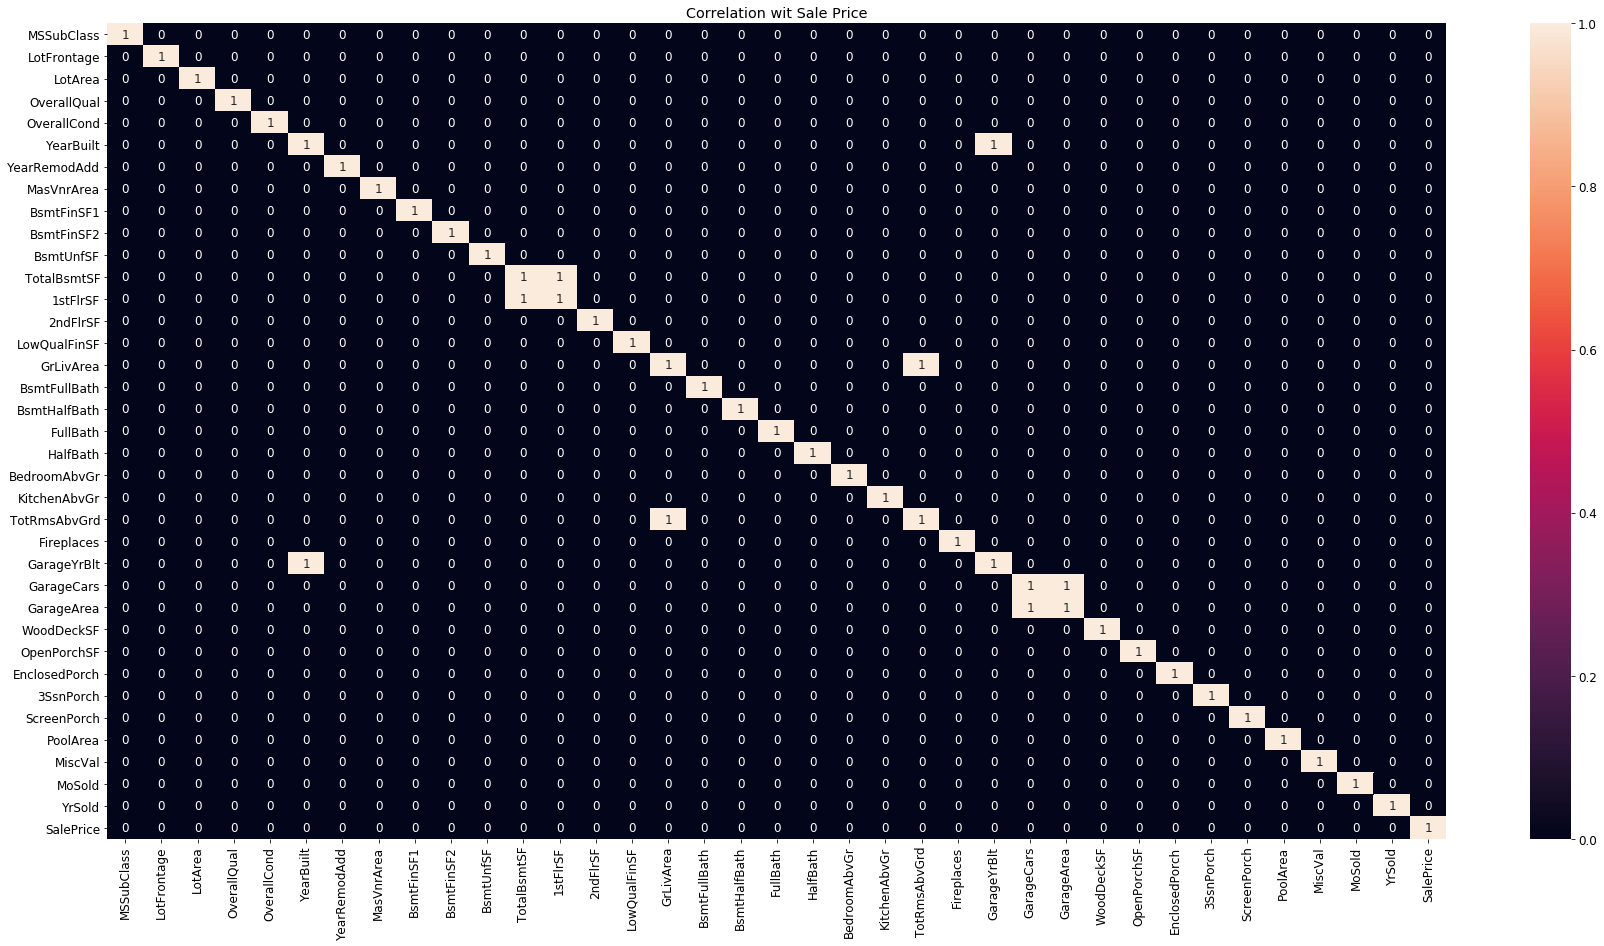

In [35]:
correlation_num = train.select_dtypes(exclude='object').corr()
plt.figure(figsize=(30,15))
plt.title('Correlation wit Sale Price')
sns.heatmap(data=correlation_num>0.80, annot=True)

# Feature Engineering

## Remove outliers

In [36]:
train = train.drop(train['LotFrontage'][train['LotFrontage']>200].index)
train = train.drop(train['LotArea'][train['LotArea']>100000].index)
train = train.drop(train['BsmtFinSF1'][train['BsmtFinSF1']>4000].index)
train = train.drop(train['TotalBsmtSF'][train['TotalBsmtSF']>6000].index)
train = train.drop(train['1stFlrSF'][train['1stFlrSF']>4000].index)
train = train.drop(train.GrLivArea[(train['GrLivArea']>4000) & (train.SalePrice<300000)].index)
train = train.drop(train.LowQualFinSF[train['LowQualFinSF']>550].index)
train.reset_index(drop=True, inplace=True)

## Sale Price ~ Normal Distribution

In [37]:
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)

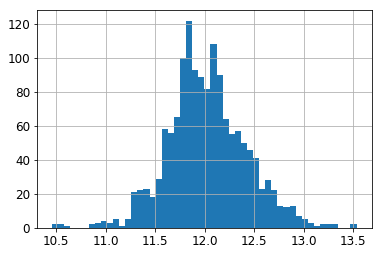

In [38]:
train['SalePrice'].hist(bins = 50)

## Extract Features

In [39]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

## Non numeric which are stored as numeric

In [40]:
#fix
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Dealing with NaNs

In [41]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features["PoolQC"] = features["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Check if there are still nans

In [42]:
lack(features)

MiscFeature     2808
Alley           2713
Fence           2341
FireplaceQu     1420
LotFrontage      483
MasVnrType        24
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
dtype: int64


In [43]:
categorical_cols = [cname for cname in features.columns if
                    features[cname].dtype == "object"]

numerical_cols = [cname for cname in features.columns if 
                features[cname].dtype in ['int64', 'float64']]

In [44]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
features.update(features[categorical_cols].fillna('None'))
features.update(features[numerical_cols].fillna(0))
lack(features)


Series([], dtype: int64)


## Dealing with skew

In [45]:
skew_features = features[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


## Simplifying features

In [46]:
features = features.drop(['Utilities', 'Street', 'PoolQC', ], axis=1)

features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

## Add some binary flags

In [47]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Dealing with categorical dummies

In [48]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

#outliers = [30, 88, 462, 631, 1322]
#X = X.drop(X.index[outliers])
#y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()


(2911, 86)
(2911, 333)
X (1452, 333) y (1452,) X_sub (1459, 333)


## 9. Creating the model

### 9.1 Importing learning libraries

In [49]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

 

### 9.2 Defining folds and score functions

In [50]:
kfolds = KFold(n_splits=18, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### 9.3 Defining models

In [51]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(),
                    SVR(C=20, epsilon=0.008, gamma=0.0003))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=42)

lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         )

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006, random_state=42)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [52]:
print('TEST score on CV')

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )




TEST score on CV
GradientBoosting score: 0.1139 (0.0192)
 2020-02-19 17:30:22.718342
Kernel Ridge score: 0.1098 (0.0179)
 2020-02-19 17:32:52.612848
Lasso score: 0.1106 (0.0175)
 2020-02-19 17:33:58.858170
ElasticNet score: 0.1107 (0.0178)
 2020-02-19 17:39:00.031934
SVR score: 0.1082 (0.0204)
 2020-02-19 17:39:26.937641
Lightgbm score: 0.1131 (0.0178)
 2020-02-19 17:40:06.865581
[17:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost score: 0.1151 (0.0180)
 2020-02-19 17:44:57.784276


In [53]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
2020-02-19 17:44:57.807155 StackingCVRegressor
[17:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2020-02-19 17:50:52.820389 elasticnet
2020-02-19 17:51

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2020-02-19 17:51:57.686693 lightgbm


### 9.6 Blend model prediction

In [54]:
def blend_models_predict(X=X):
    return ((0.1* elastic_model_full_data.predict(X)) + 
            (0.1 * lasso_model_full_data.predict(X)) + 
            (0.05 * ridge_model_full_data.predict(X)) + 
            (0.1 * svr_model_full_data.predict(X)) + 
            (0.1 * gbr_model_full_data.predict(X)) + 
            (0.15 * xgb_model_full_data.predict(X)) + 
            (0.1 * lgb_model_full_data.predict(X)) + 
            (0.3 * stack_gen_model.predict(np.array(X))))


In [55]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.06124141358827378


## 10 Submission

In [56]:
print('Predict submission')
preds_test = np.expm1(blend_models_predict(X_sub))

output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': preds_test})
output.to_csv('submission1.csv', index=False)

Predict submission
